In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [210]:
df = pd.read_csv(r"C:\Users\trainee\Desktop\knn_imputed_dataset_finalll.csv")

In [211]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 411773


In [212]:
# Drop duplicate rows
df = df.drop_duplicates()

# Reset index if needed
df = df.reset_index(drop=True)

print("Duplicates removed. New shape:", df.shape)

Duplicates removed. New shape: (1488395, 14)


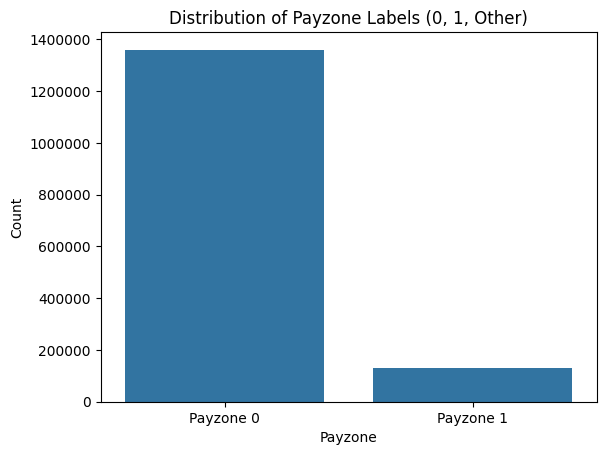

In [213]:
# Step 3: Define payzone 
df['payzone'] = ((df['phi'] > 0.12) & 
                 (df['sw'] < 0.5) & 
                 (df['GR'] <= 75) & 
                 (df['RILD'] >= 10) & 
                 (df['MN'] > 0.2)).astype(int)

# Exception rules to override possible false positives
df.loc[df['GR'] > 90, 'payzone'] = 0      # Too radioactive
df.loc[df['phi'] < 0.05, 'payzone'] = 0   # Too tight
df.loc[df['RILD'] < 2, 'payzone'] = 0     # Too conductive (likely brine)


# Plot updated labels
df_plot = df.copy()
df_plot['payzone_label'] = df_plot['payzone'].apply(lambda x: 'Payzone 1' if x == 1 
                                                    else 'Payzone 0' if x == 0 
                                                    else 'Other/Unknown')

sns.countplot(x='payzone_label', data=df_plot)
plt.title("Distribution of Payzone Labels (0, 1, Other)")
plt.xlabel("Payzone")
plt.ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [214]:
print(df.head())

     DEPT     RHOB     RHOC      DPOR        GR     RILM      RLL3      RILD  \
0  3185.5  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
1  3185.0  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
2  3184.5  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
3  3184.0  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
4  3183.5  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   

        MN      CNLS     WELL_ID  WELL_INDEX       phi       sw  payzone  
0  4.78984  25.10352  1055282622       124.0  0.155925  0.55665        0  
1  4.78984  25.10352  1055282622       124.0  0.155925  0.55665        0  
2  4.78984  25.10352  1055282622       124.0  0.155925  0.55665        0  
3  4.78984  25.10352  1055282622       124.0  0.155925  0.55665        0  
4  4.78984  25.10352  1055282622       124.0  0.155925  0.55665        0  


In [215]:
df = df.drop(['RHOB', 'DPOR',], axis=1)

In [216]:
print(df.head())

     DEPT     RHOC        GR     RILM      RLL3      RILD       MN      CNLS  \
0  3185.5  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
1  3185.0  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
2  3184.5  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
3  3184.0  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
4  3183.5  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   

      WELL_ID  WELL_INDEX       phi       sw  payzone  
0  1055282622       124.0  0.155925  0.55665        0  
1  1055282622       124.0  0.155925  0.55665        0  
2  1055282622       124.0  0.155925  0.55665        0  
3  1055282622       124.0  0.155925  0.55665        0  
4  1055282622       124.0  0.155925  0.55665        0  


In [217]:
drop_cols = ['payzone']  # Only drop target here

X = df.drop(columns=drop_cols)  # WELL_INDEX and WELL_ID are kept in X now
y = df['payzone']


well_info = df[['WELL_INDEX', 'WELL_ID']]

In [218]:
# Moving averages 
for col in ['GR', 'phi', 'RILD']:
    df[f'{col}_ma3'] = df.groupby('WELL_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_delta'] = df.groupby('WELL_ID')[col].transform(lambda x: x.diff().fillna(0))

In [219]:
Sampling 60/20/20
# Columns to ignore during training but keep for merging later
ignore_cols = ['WELL_INDEX', 'WELL_ID']

# Separate features for training by dropping ignored columns (but NOT target)
X_features = X.drop(columns=ignore_cols)

# Stratified split for 60/20/20
from sklearn.model_selection import train_test_split

# 60% train, 40% temp
X_train_feat, X_temp_feat, y_train, y_temp = train_test_split(
    X_features, y, test_size=0.4, stratify=y, random_state=42)

# 20% val, 20% test from 40%
X_val_feat, X_test_feat, y_val, y_test = train_test_split(
    X_temp_feat, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Get the ignored columns (wellname, wellid) from original X for later use
X_train_ignore = X.loc[X_train_feat.index, ignore_cols]
X_val_ignore = X.loc[X_val_feat.index, ignore_cols]
X_test_ignore = X.loc[X_test_feat.index, ignore_cols]

# Final datasets (no scaling needed)
from sklearn.model_selection import GroupShuffleSplit

# Columns to ignore during training but keep for merging later
ignore_cols = ['WELL_INDEX', 'WELL_ID']

# Separate features
X_features = X.drop(columns=ignore_cols)

# 60% train, 40% temp using group split by WELL_ID
gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, temp_idx = next(gss.split(X_features, y, groups=X['WELL_ID']))

X_train_feat = X_features.iloc[train_idx]
y_train = y.iloc[train_idx]
X_temp_feat = X_features.iloc[temp_idx]
y_temp = y.iloc[temp_idx]
WELL_ID_temp = X.iloc[temp_idx]['WELL_ID']

# 20% val, 20% test from temp (split again by WELL_ID)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss2.split(X_temp_feat, y_temp, groups=WELL_ID_temp))

X_val_feat = X_temp_feat.iloc[val_idx]
y_val = y_temp.iloc[val_idx]
X_test_feat = X_temp_feat.iloc[test_idx]
y_test = y_temp.iloc[test_idx]

# Restore ignored columns
X_train_ignore = X.loc[X_train_feat.index, ignore_cols]
X_val_ignore = X.loc[X_val_feat.index, ignore_cols]
X_test_ignore = X.loc[X_test_feat.index, ignore_cols]

In [220]:
# Exclude rule-defining features temporarily
X_train_no_leak = X_train_feat.drop(columns=['phi', 'sw', 'GR', 'RILD', 'MN'])
X_test_no_leak = X_test_feat.drop(columns=['phi', 'sw', 'GR', 'RILD', 'MN'])

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train_no_leak, y_train)
y_pred_leak_test = rf.predict(X_test_no_leak)

print("Leakage check metrics:")
print(classification_report(y_test, y_pred_leak_test))

Leakage check metrics:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    269204
           1       0.69      0.49      0.57     25260

    accuracy                           0.94    294464
   macro avg       0.82      0.73      0.77    294464
weighted avg       0.93      0.94      0.93    294464



In [221]:
print(y.value_counts(normalize=True))

payzone
0    0.913673
1    0.086327
Name: proportion, dtype: float64


In [222]:
#MODEL RF
rf_params = {
    'n_estimators': 150,
    'max_depth': 12,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 42
}

In [223]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier using raw training features
rf_classifier = RandomForestClassifier(**rf_params)
rf_classifier.fit(X_train_feat, y_train)

# Predict on raw test features
y_pred = rf_classifier.predict(X_test_feat)


RF Evaluation Metrics:

Confusion Matrix:
[[269204      0]
 [     4  25256]]

Precision     : 1.0000
Recall        : 0.9998
F1 Score      : 0.9999


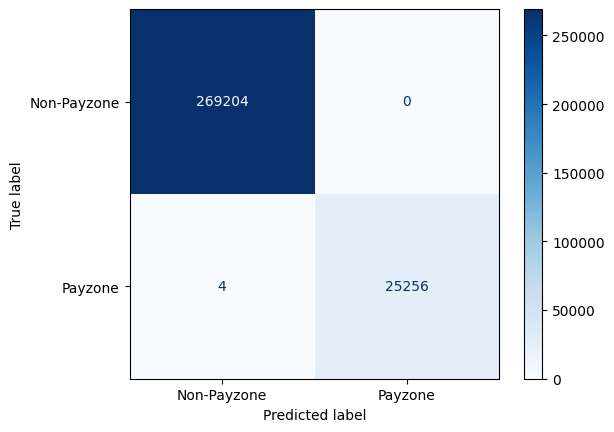

In [224]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

print("\nRF Evaluation Metrics:")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Payzone", "Payzone"])
disp.plot(cmap="Blues")


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_proba) 

print(f"\nPrecision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
# print(f"ROC AUC Score : {roc_auc:.4f}")


🔍 Extra Trees Evaluation Metrics:

Precision     : 0.9877
Recall        : 0.9736
F1 Score      : 0.9806


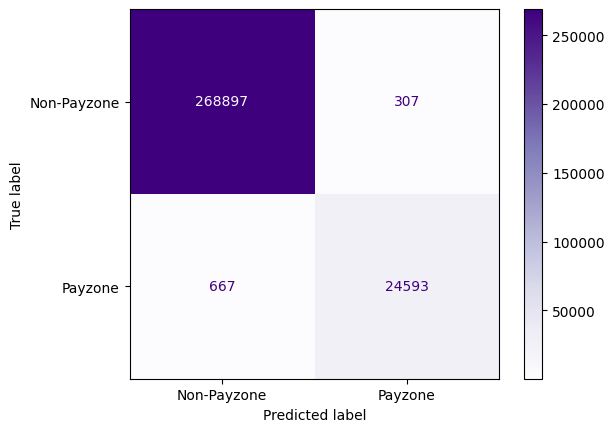

In [225]:
# Extra Trees Classifier to test robustness
from sklearn.ensemble import ExtraTreesClassifier

et_params = {
    'n_estimators': 150,
    'max_depth': 12,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': False,  
    'random_state': 42
}

et_classifier = ExtraTreesClassifier(**et_params)
et_classifier.fit(X_train_feat, y_train)
y_pred_et = et_classifier.predict(X_test_feat)

print("\n🔍 Extra Trees Evaluation Metrics:")
cm_et = confusion_matrix(y_test, y_pred_et)
disp_et = ConfusionMatrixDisplay(confusion_matrix=cm_et, display_labels=["Non-Payzone", "Payzone"])
disp_et.plot(cmap="Purples")

precision_et = precision_score(y_test, y_pred_et)
recall_et = recall_score(y_test, y_pred_et)
f1_et = f1_score(y_test, y_pred_et)

print(f"\nPrecision     : {precision_et:.4f}")
print(f"Recall        : {recall_et:.4f}")
print(f"F1 Score      : {f1_et:.4f}")

In [226]:
import pandas as pd

results = pd.DataFrame({
    'WELL_ID': X_test_ignore['WELL_ID'].values,
    'true': y_test.values,
    'pred': y_pred_et  # or any model
})

# Per well evaluation
well_stats = results.groupby('WELL_ID').apply(lambda g: pd.Series({
    'precision': precision_score(g['true'], g['pred'], zero_division=0),
    'recall': recall_score(g['true'], g['pred'], zero_division=0),
    'f1': f1_score(g['true'], g['pred'], zero_division=0)
}))

print(well_stats.describe())


       precision     recall         f1
count  38.000000  38.000000  38.000000
mean    0.986382   0.963981   0.974623
std     0.016174   0.040405   0.024963
min     0.909692   0.774194   0.857143
25%     0.986382   0.954603   0.971803
50%     0.990725   0.976660   0.983881
75%     0.994487   0.986679   0.987470
max     1.000000   0.997585   0.992908


C:\Users\trainee\AppData\Local\Temp\ipykernel_23852\1357650088.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  well_stats = results.groupby('WELL_ID').apply(lambda g: pd.Series({


In [227]:
#XGB
import xgboost as xgb

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()  #to handle class imbalance

xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [228]:
# Train model on raw (unscaled) data
xgb_clf.fit(X_train_feat, y_train)

# Predict on raw test data
y_pred = xgb_clf.predict(X_test_feat)
y_prob = xgb_clf.predict_proba(X_test_feat)[:, 1]

C:\Users\trainee\anaconda3\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [11:59:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGB Evaluation Metrics:

Confusion Matrix:
[[269114     90]
 [    36  25224]]


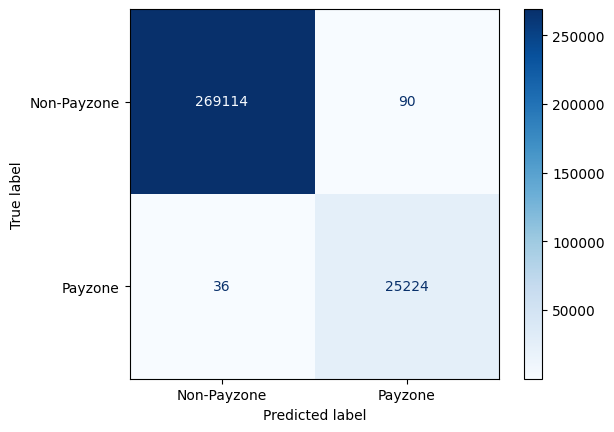


Precision     : 0.9964
Recall        : 0.9986
F1 Score      : 0.9975
ROC AUC Score : 1.0000


In [229]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

print("\nXGB Evaluation Metrics:")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Payzone", "Payzone"])
disp.plot(cmap="Blues")
plt.show()

# Precision, Recall, F1, ROC AUC
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)  # y_prob = xgb_clf.predict_proba(X_test)[:, 1]

print(f"\nPrecision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC Score : {roc_auc:.4f}")


In [206]:
# Code for creating a directory of the test data well-wise
import os
import pandas as pd
import re

test_df = pd.concat([X_test_feat, X_test_ignore, y_test.rename("TARGET")], axis=1)

output_dir = 'test_well_data'
os.makedirs(output_dir, exist_ok=True)

def sanitize_filename(name):
    """Remove or replace characters that are unsafe in file names."""
    return re.sub(r'[\\/*?:"<>|]', "_", str(name))

for well_name, group in test_df.groupby('WELL_ID'):
    safe_name = sanitize_filename(well_name)
    file_path = os.path.join(output_dir, f"{safe_name}.csv")
    group.to_csv(file_path, index=False)

print(f"✅ Exported {len(os.listdir(output_dir))} test well files to '{output_dir}/'")

✅ Exported 188 test well files to 'test_well_data/'


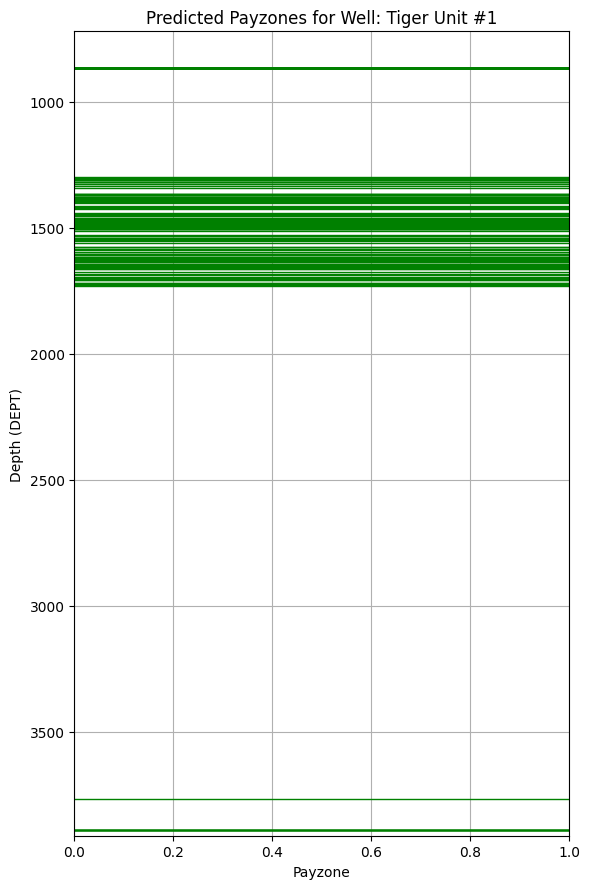

In [230]:
#plto of one well (from the test data) XGB
import os
import pandas as pd
import matplotlib.pyplot as plt

file_path = r'C:\Users\trainee\Desktop\test_well_data\Tiger Unit #1.csv'
well_df = pd.read_csv(file_path)

well_name = os.path.splitext(os.path.basename(file_path))[0]  

feature_cols = ['DEPT', 'RHOC', 'GR', 'RILM', 'RLL3', 'RILD', 'MN', 'CNLS', 'phi', 'sw']
X_input = well_df[feature_cols]

y_pred = xgb_clf.predict(X_input)

well_df['PREDICTED_PAYZONE'] = y_pred

well_df = well_df.sort_values(by='DEPT')

plt.figure(figsize=(6, 9))  

payzone_depths = well_df[well_df['PREDICTED_PAYZONE'] == 1]['DEPT']

for depth in payzone_depths:
    plt.axhline(y=depth, color='green', linestyle='-', linewidth=1)

if len(well_df) <= 100:  
    plt.yticks(well_df['DEPT'])

plt.gca().invert_yaxis()  
plt.xlabel("Payzone")
plt.ylabel("Depth (DEPT)")
plt.title(f"Predicted Payzones for Well: {well_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

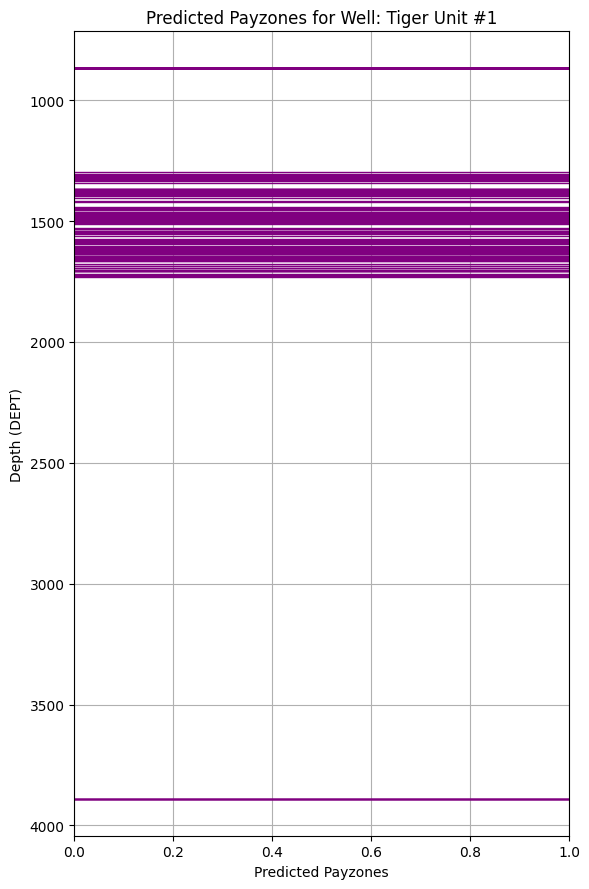

In [234]:
import os                      #ET
import pandas as pd
import matplotlib.pyplot as plt

file_path = r'C:\Users\trainee\Desktop\test_well_data\Tiger Unit #1.csv'
well_df = pd.read_csv(file_path)

well_name = os.path.splitext(os.path.basename(file_path))[0]

feature_cols = ['DEPT', 'RHOC', 'GR', 'RILM', 'RLL3', 'RILD', 'MN', 'CNLS', 'phi', 'sw']
X_input = well_df[feature_cols]

y_pred = et_classifier.predict(X_input)

well_df['PREDICTED_PAYZONE'] = y_pred

well_df = well_df.sort_values(by='DEPT')

plt.figure(figsize=(6, 9))

payzone_depths = well_df[well_df['PREDICTED_PAYZONE'] == 1]['DEPT']

for depth in payzone_depths:
    plt.axhline(y=depth, color='purple', linestyle='-', linewidth=1)

if len(well_df) <= 100:
    plt.yticks(well_df['DEPT'])

plt.gca().invert_yaxis()
plt.xlabel("Predicted Payzones")
plt.ylabel("Depth (DEPT)")
plt.title(f"Predicted Payzones for Well: {well_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

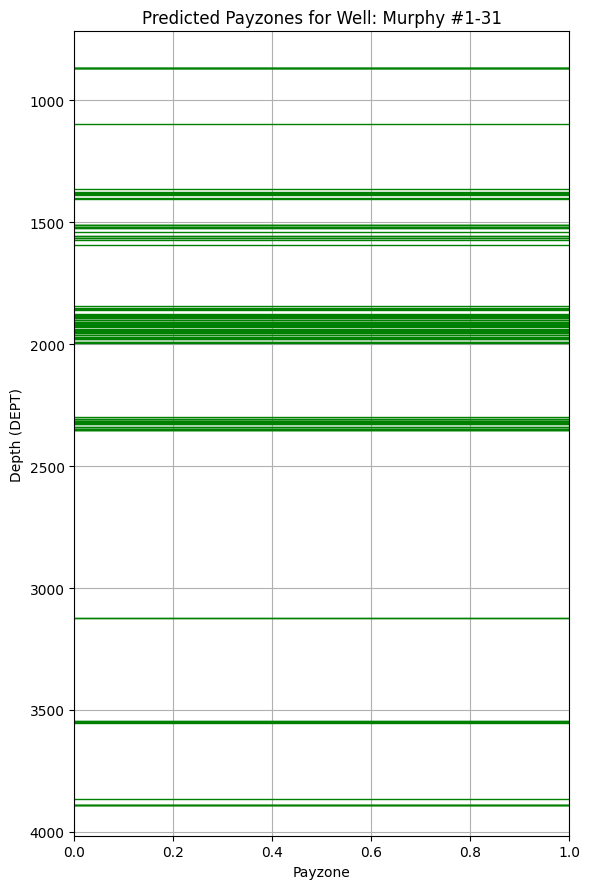

In [231]:
#plot of one well (from the test data)          XGB
import os
import pandas as pd
import matplotlib.pyplot as plt

file_path = r'C:\Users\trainee\Desktop\test_well_data\Murphy #1-31.csv'
well_df = pd.read_csv(file_path)

well_name = os.path.splitext(os.path.basename(file_path))[0]  # Get file name without extension

feature_cols = ['DEPT', 'RHOC', 'GR', 'RILM', 'RLL3', 'RILD', 'MN', 'CNLS', 'phi', 'sw']
X_input = well_df[feature_cols]

y_pred = xgb_clf.predict(X_input)

well_df['PREDICTED_PAYZONE'] = y_pred

well_df = well_df.sort_values(by='DEPT')

plt.figure(figsize=(6, 9))  # Dynamically adjust height based on number of rows

payzone_depths = well_df[well_df['PREDICTED_PAYZONE'] == 1]['DEPT']

for depth in payzone_depths:
    plt.axhline(y=depth, color='green', linestyle='-', linewidth=1)

if len(well_df) <= 100:  # Only set ticks if not too many
    plt.yticks(well_df['DEPT'])

plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel("Payzone")
plt.ylabel("Depth (DEPT)")
plt.title(f"Predicted Payzones for Well: {well_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

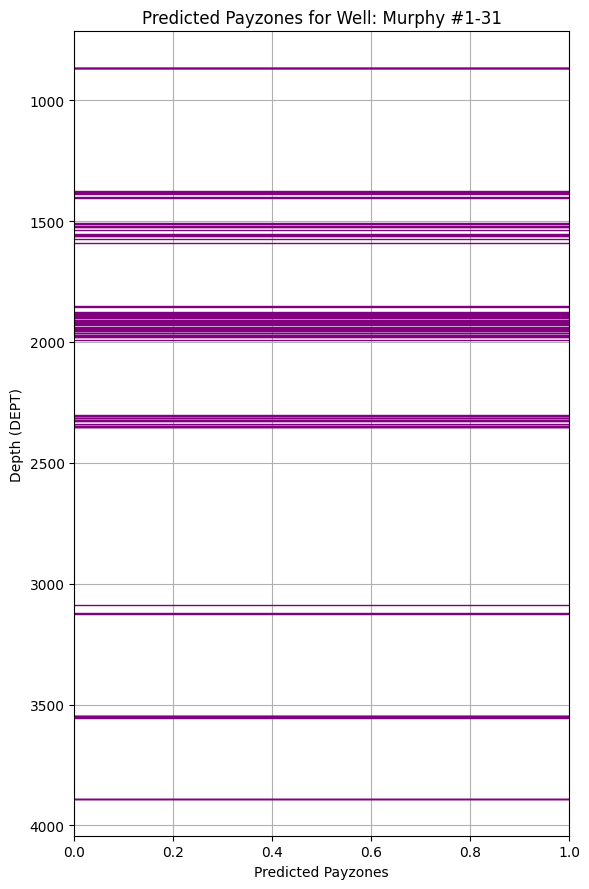

In [236]:
#  Plot payzone  using Extra Trees model
import os
import pandas as pd
import matplotlib.pyplot as plt

file_path = r'C:\Users\trainee\Desktop\test_well_data\Murphy #1-31.csv'
well_df = pd.read_csv(file_path)

well_name = os.path.splitext(os.path.basename(file_path))[0]

feature_cols = ['DEPT', 'RHOC', 'GR', 'RILM', 'RLL3', 'RILD', 'MN', 'CNLS', 'phi', 'sw']
X_input = well_df[feature_cols]

y_pred = et_classifier.predict(X_input)

well_df['PREDICTED_PAYZONE'] = y_pred

well_df = well_df.sort_values(by='DEPT')

plt.figure(figsize=(6, 9))

payzone_depths = well_df[well_df['PREDICTED_PAYZONE'] == 1]['DEPT']

for depth in payzone_depths:
    plt.axhline(y=depth, color='purple', linestyle='-', linewidth=1)

if len(well_df) <= 100:
    plt.yticks(well_df['DEPT'])

plt.gca().invert_yaxis()
plt.xlabel("Predicted Payzones")
plt.ylabel("Depth (DEPT)")
plt.title(f"Predicted Payzones for Well: {well_name}")
plt.grid(True)
plt.tight_layout()
plt.show()